In [ ]:
!wget -O ./ldm_uncond/ldm-celebahq-256/unet/diffusion_pytorch_model.bin https://huggingface.co/CompVis/ldm-celebahq-256/resolve/main/unet/diffusion_pytorch_model.bin
!wget -O ./ldm_uncond/ldm-celebahq-256/vqvae/diffusion_pytorch_model.bin https://huggingface.co/CompVis/ldm-celebahq-256/resolve/main/vqvae/diffusion_pytorch_model.bin

In [2]:
import json
from collections import OrderedDict
from ldm_uncond.latent_diffusion_uncond import LDMPipeline
from ldm_uncond.model.unet import UNet2DModel
from ldm_uncond.model.vq import VQModel
from ldm_uncond.model.ddim_scheduler import DDIMScheduler
from ldm_uncond.model.eulera_scheduler import EulerAncestralDiscreteScheduler
import torch
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Initialize models and load weights

unet_root = "ldm_uncond/ldm-celebahq-256/unet/"
vqvae_root = "ldm_uncond/ldm-celebahq-256/vqvae/"
scheduler_root = "ldm_uncond/ldm-celebahq-256/scheduler/"

with open(unet_root + "config.json", 'r') as f:
    unet_config = json.load(f)
with open(vqvae_root + "config.json", 'r') as f:
    vqvae_config = json.load(f)
with open(scheduler_root + "scheduler_config.json", 'r') as f:
    scheduler_config = json.load(f)


unet = UNet2DModel(**unet_config)
vqvae = VQModel(**vqvae_config)
scheduler = DDIMScheduler(**scheduler_config)
# scheduler = EulerAncestralDiscreteScheduler(**scheduler_config)


unet_state_dict = torch.load(unet_root + "diffusion_pytorch_model.bin", map_location='cpu')
unet_state_dict_new = OrderedDict()

for k, v in unet_state_dict.items():
    if k.startswith("mid_block.resnets.0"):
        name = k.replace('resnets.0', 'resnets_0')
    elif k.startswith("mid_block.resnets"):
        i = int(k[18])
        name = k[:18] + str(i-1) + k[19:]
    else:
        name = k
    unet_state_dict_new[name] = v

unet.load_state_dict(unet_state_dict_new)


vqvae_state_dict = torch.load(vqvae_root + "diffusion_pytorch_model.bin", map_location='cpu')
vqvae_state_dict_new = OrderedDict()

for k, v in vqvae_state_dict.items():
    if "mid_block.resnets.0" in k:
        name = k.replace('resnets.0', 'resnets_0')
    elif "mid_block.resnets" in k:
        name = re.sub(r"resnets.(\d+)", lambda match: "resnets." + str(int(match.group(1))-1), k)
    else:
        name = k
    vqvae_state_dict_new[name] = v


vqvae.load_state_dict(vqvae_state_dict_new)


del unet_state_dict, unet_state_dict_new, vqvae_state_dict, vqvae_state_dict_new

diffusion_pipeline = LDMPipeline(vqvae, unet, scheduler)

# Generate Sample

In [5]:
DTYPE = torch.float32
DEVICE = torch.device('cuda')
diffusion_pipeline.num_inference_steps = 20

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)

In [6]:
## Generate sample

with torch.no_grad():
    # with torch.autocast(device_type='cuda', dtype=torch.float16):
    diffusion_pipeline.eval()
    noise = torch.randn((1, 3, 64, 64), dtype=DTYPE, device=DEVICE)
    sample = diffusion_pipeline(noise)

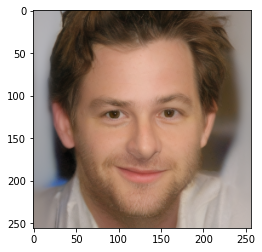

In [7]:
## Visualize sample

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(sample.cpu().float().numpy()[0]/255)

# TorchScript Compilation

In [ ]:
DTYPE = torch.float32
DEVICE = torch.device('cpu')

diffusion_pipeline = diffusion_pipeline.to(device=DEVICE, dtype=DTYPE)

with torch.no_grad():
    diffusion_pipeline.eval()
    example = torch.randn((1, 3, 64, 64),  dtype=DTYPE, device=DEVICE)
    torchscript_model = torch.jit.trace(diffusion_pipeline, example)

torch.jit.save(torchscript_model, "model_unoptimized.ptl")

In [2]:
# Might need to restart kernel after the previous cell to prevent running out of memory

# Optimize for mobile

from torch.utils.mobile_optimizer import optimize_for_mobile

torchscript_model = torch.jit.load("model_unoptimized.ptl")
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, "model.ptl")
torchscript_model_optimized._save_for_lite_interpreter("model_lite.ptl")

In [6]:
with torch.no_grad():
    noise = torch.randn((1, 3, 64, 64), dtype=DTYPE, device=DEVICE)
    mobile_output = torchscript_model_optimized(noise)

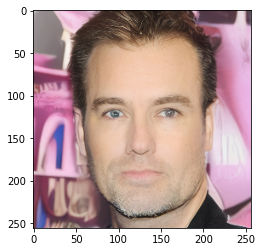

In [7]:
import matplotlib.pyplot as plt
plt.imshow(mobile_output.numpy()[0]/255)

In [ ]:
# TODO: Load correct weights - done
# TODO: make GPU compatible - done
# TODO: Use fp16 - done
# TODO: Compare outputs to test correctness - done
# TODO: Make better scheduler work